In [404]:
import numpy as np
import scipy.io as sio
from glob import glob
from tqdm import tqdm
from scipy.signal import convolve2d
from scipy.interpolate import RectBivariateSpline
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
from astropy.modeling import models, fitting
import astropy.units as u
import pickle
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
sys.path.append('../python/')
import chroma
%matplotlib inline
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'

In [405]:

h=fits.open(infile)
output=h[0].header['OUTPUT']
module=h[0].header['MODULE']
print module,output

12 1


In [406]:
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,module,module+0.1*output))
lam=np.asarray([(f.split('_')[-1])[0:-4] for f in fnames],dtype='float')

psf_model=np.zeros((len(fnames),50,50))

for l in tqdm(xrange(len(fnames))):
    h=sio.loadmat(fnames[0])
    psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
    res=h['grid_res'][0][0]
    lam=[]
    for i,f in enumerate(fnames):
        h=sio.loadmat(f)
        psf[i,:,:]=h['psf']
        lam.append(f.split('_')[-1][0:-4])

    PRFx = np.arange(0., np.shape(psf[0])[0] + 0.)-np.shape(psf[0])[0]/2
    PRFy = np.arange(0., np.shape(psf[0])[1] + 0.)-np.shape(psf[0])[0]/2
    PRFx*=0.03
    PRFy*=0.03
    PRFX,PRFY=np.meshgrid(PRFx,PRFy)    
    cx=PRFX[0][np.where(PRFX[0]>=0)[0][0]:np.where(PRFX[0]<1)[0][-1]]
    cy=PRFY[:,0][np.where(PRFY[:,0]>=0)[0][0]:np.where(PRFY[:,0]<1)[0][-1]]
    cx,cy=np.meshgrid(cx,cy)
    prf=np.copy(cx)*0.+1.
    psf_c=convolve2d(psf[l,:,:],prf,mode='same')

    psf_c/=np.nansum(psf_c)

    model=RectBivariateSpline(PRFx,PRFy,psf_c)
    X,Y=np.meshgrid(np.linspace(-3,3,50),np.linspace(-3,3,50))

    PRFX,PRFY,psf_c=X,Y,model(X[0],Y[:,0])
    psf_model[l,:,:]=psf_c
pickle.dump(psf_model,open('psf_model.p','wb'))


 25%|██▌       | 6/24 [00:07<00:23,  1.33s/it]

100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


In [407]:
psf_model=pickle.load(open('psf_model.p','rb'))

In [408]:
fit=fitting.LevMarLSQFitter()
X,Y=np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,module,module+output*0.1))
lam=np.asarray([(f.split('_')[-1])[0:-4] for f in fnames],dtype='float')


psf_xshifts=np.zeros(np.shape(psf_model)[1])
psf_yshifts=np.zeros(np.shape(psf_model)[1])

for l in (xrange(len(fnames))):
    g_init=models.Gaussian2D(x_mean=0,y_mean=0,amplitude=np.max(psf_model[l,:,:]))
    g=fit(g_init,X,Y,psf_model[l,:,:])
    psf_xshifts[l],psf_yshifts[l]=g.x_mean.value,g.y_mean.value

In [409]:
#BANDPASS

temperature=9300*u.K
flux_lam = blackbody_lambda(np.asarray(lam,dtype=float)*u.nanometer, temperature)
psf2d=np.zeros((np.shape(psf_model)[1],np.shape(psf_model)[2]))
for l,w in enumerate(flux_lam):
    psf2d+=w.value*psf_model[l,:,:]
psf2d/=chroma.trapezoidal_area(np.transpose([X.ravel(),Y.ravel(),psf2d.ravel()]))

In [410]:
dt=500
nt=50
resids=np.zeros((nt,np.shape(psf2d)[0],np.shape(psf2d)[1]))
ts=['{}K'.format(int(i)) for i in np.round(np.linspace(temperature.value-dt,temperature.value+dt,nt),-2)]
for i,temp in enumerate(np.linspace(temperature.value-dt,temperature.value+dt,nt)*u.K):
    flux_lam = blackbody_lambda(np.asarray(lam,dtype=float)*u.nanometer, temp)
    h=np.zeros((np.shape(psf_model)[1],np.shape(psf_model)[2]))
    for l,w in enumerate(flux_lam):
        h+=w.value*psf_model[l,:,:]
    h/=chroma.trapezoidal_area(np.transpose([X.ravel(),Y.ravel(),h.ravel()]))
    resids[i,:,:]=h-psf2d

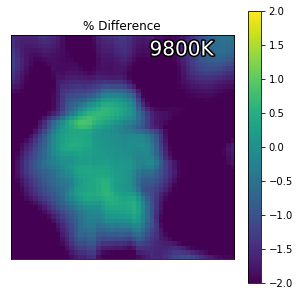

In [411]:
reload(chroma)
chroma.animateim(100.*resids/psf2d,labels=ts,outfile='../images/test.mp4',vmin=-2,vmax=2,colorbar=True,title='% Difference')

KIC 8823397
12 1


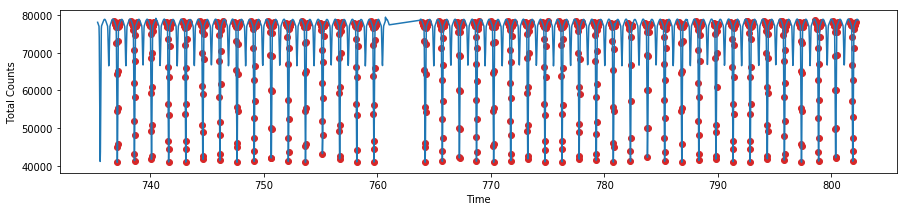

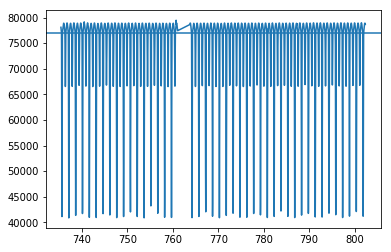

In [368]:
import chroma
reload(chroma)
infile='../data/EB7.fits'
h=fits.open(infile)
print h[0].header['OBJECT']
print h[0].header['MODULE'],h[0].header['OUTPUT']
data=h[1].data['FLUX']
time=h[1].data['TIME']
times=chroma.fluxplot(infile,plot=True,std=2)
times=np.append(times,'763:765')
plt.figure()
y=np.nansum(np.nansum(data,axis=1),axis=1)
plt.plot(time[y!=0],y[y!=0])
plt.axhline(77000)

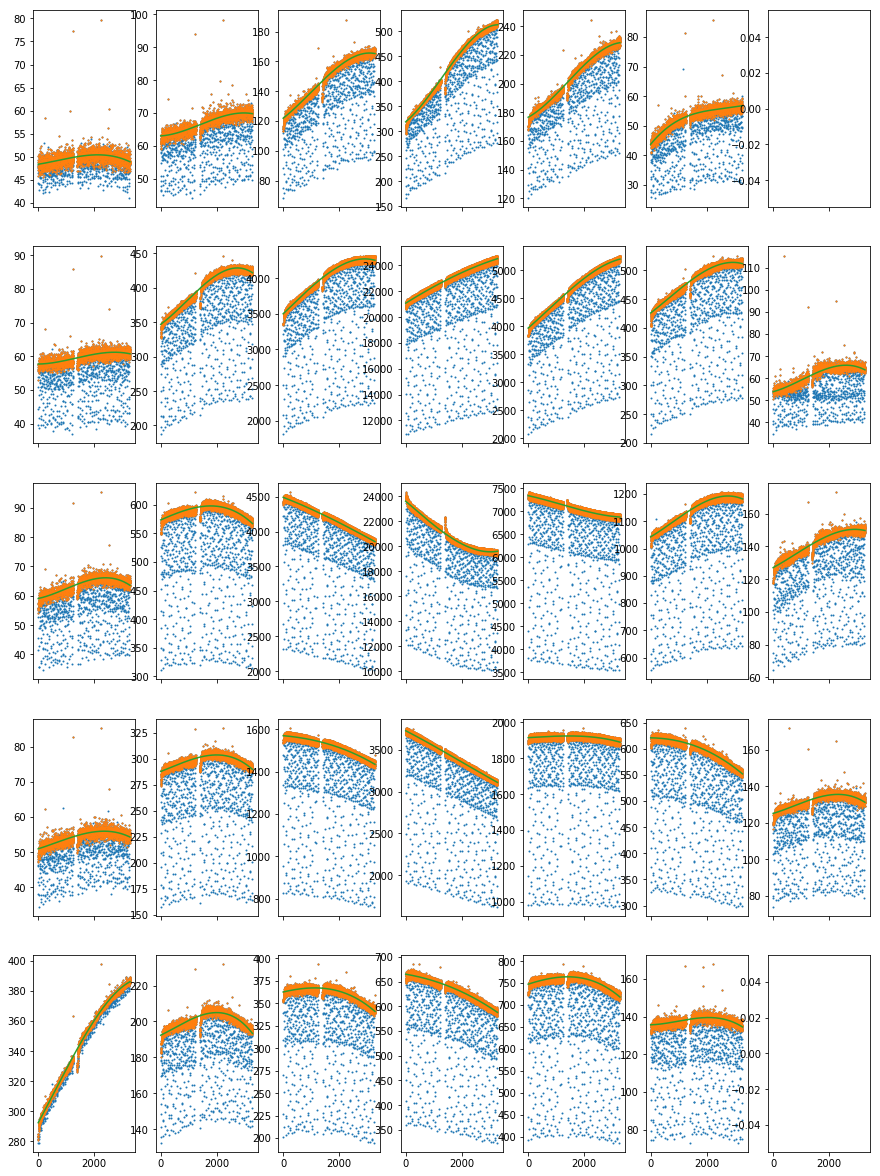

In [369]:
s=np.shape(data)
shape_model=np.zeros((s[0],s[1],s[2]))
fig,ax=plt.subplots(s[1],s[2],figsize=(s[2]*3,s[1]*3),sharex=True)
for i in xrange(s[1]):
    for j in xrange(s[2]):
        x,y=np.arange(len(data)),data[:,i,j]
        good=chroma.qualify(time,data,times)
        good=np.where((np.nansum(np.nansum(data,axis=1),axis=1)!=0)&(np.nansum(np.nansum(data,axis=1),axis=1)>77000))
        if len(good)==0:
                continue

        flat=np.polyval(np.polyfit(x[good],y[good],3),x)
        shape_model[:,i,j]=flat
        ax[i,j].scatter(x,y,s=1)
        ax[i,j].scatter(x[good],y[good],s=1)
        ax[i,j].plot(x,flat,c='C2')


In [370]:
from scipy.optimize import minimize

In [371]:
flux=[]
for dat,mod in zip(data,shape_model):
    def psf(scale):
        return 1./float(len(dat.ravel()))*np.nansum((dat-scale*mod)**2/dat)
    initial_guess=np.nanmean(dat)/np.nanmean(mod)
    f=minimize(psf,initial_guess)
    flux.append(f.x[0])
fluxmodels=np.asarray([f*m for f,m in zip(flux,shape_model)])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


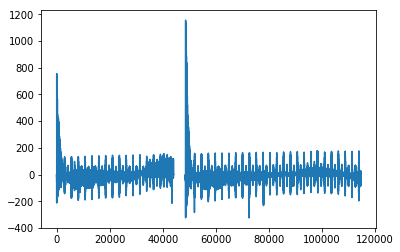

In [372]:
plt.plot(data.ravel()-fluxmodels.ravel())

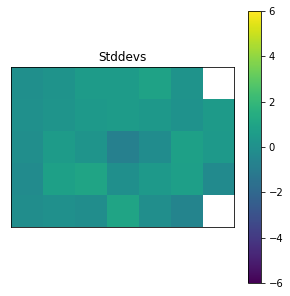

In [373]:
reload(chroma)
stds=(np.nanstd((data-fluxmodels)/data,axis=0))
vals=(data-fluxmodels)/data


chroma.animateim(vals/stds,vmin=-6,vmax=6,colorbar=True,title='Stddevs',outfile='EB6.mp4')

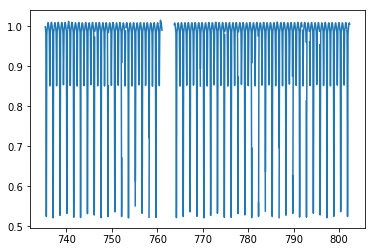

In [374]:
plt.plot(time,flux)